# Carbon Lighthouse timed work sample
Stephen Klosterman, steve.klosterman@gmail.com


In [2]:
#Load the data
path = './carbonlighthousedatascientistmodeldevelopmentworks/'

In [3]:
training_data = 'Measured_Data.csv'
predictions_data = 'Predicted_Weather.csv'

In [5]:
#Import packages
import pandas as pd
import io
import requests
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn

In [125]:
df_train = pd.read_csv(path + training_data)

In [126]:
df_train.head()

,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity,ThermalCoolingLoad
0,2/27/2017 0:00,0,44.240,85.33,0.0
1,2/27/2017 0:15,0,46.238,82.58,0.0
2,2/27/2017 0:30,0,50.630,74.88,0.0
3,2/27/2017 0:45,0,49.748,77.29,0.0
4,2/27/2017 1:00,0,50.234,76.31,0.0


In [12]:
#How much data is there?
df_train.count()

Datetime                   3665
BuildingOccupied           3665
OutdoorTemperature         3665
OutdoorRelativeHumidity    3665
ThermalCoolingLoad         3665
dtype: int64

In [11]:
#Does the training data have five weeks of observations every 15 minutes?
5*7*24*4

3360

Looks like yes

In [8]:
df_predict = pd.read_csv(path + predictions_data)

In [9]:
df_predict.head()

,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity
0,1/1/2018 0:00,0,48.2,87
1,1/1/2018 0:30,0,48.2,87
2,1/1/2018 1:00,0,50.0,82
3,1/1/2018 1:30,0,50.0,82
4,1/1/2018 2:00,0,50.0,82


In [13]:
df_predict.count()

Datetime                   17520
BuildingOccupied           17520
OutdoorTemperature         17520
OutdoorRelativeHumidity    17520
dtype: int64

In [14]:
365*24*2

17520

Looks like right number of rows here as well.

# Data exploration
Is there missing data?

In [17]:
df_train.isnull().sum()

Datetime                   0
BuildingOccupied           0
OutdoorTemperature         0
OutdoorRelativeHumidity    0
ThermalCoolingLoad         0
dtype: int64

In [18]:
df_predict.isnull().sum()

Datetime                   0
BuildingOccupied           0
OutdoorTemperature         0
OutdoorRelativeHumidity    0
dtype: int64

No missing values in either data set.

What does the training data look like?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11833fe90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118016410>]], dtype=object)

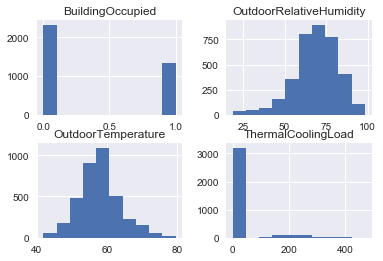

In [19]:
df_train.hist()

How about the prediction data?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1185940d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118766710>]], dtype=object)

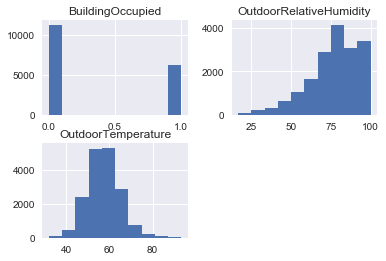

In [20]:
df_predict.hist()

There is quite a bit more humid weather in the data to be predicted, that is not present in the training data. Since the model won't be trained as much in this region of parameter space, it may be that predictions for times of high humidity won't be as good.

Outdoor temperatures look similar, as does the proportion of time the building is occupied.

In the training data, the vast majority of the time, the thermal load is very small or zero, indicating the cooling system was not working very much of the time. I wonder is this typical, and whether data from times of more frequent operation would be available?

How much of the time is the cooling load equal to zero?

In [24]:
sum(df_train.ThermalCoolingLoad.values == 0) / float(len(df_train.ThermalCoolingLoad.values))

0.8739427012278308

It is exactly zero most of the time.

## Initial thoughts on modeling
I'll assume the cooling load at time T is a linear function of building occupancy status, humidity, and temperature.

Due to the large number of zeroes, the response variable is definitely not normally distributed. This may create issues in multi-linear regression, and possibly other regression methods as well. It may be beneficial to create a two-part model:
1. Is the cooling system on or not?
2. Given the cooling system is on, how many units are being used?

It also stands to reason that the cooling needed at time T is not just a function of the temperature at time T, but also previous time steps. A time series regression approach seems like probably the best thing.

There are a few different approaches possible here. One is distributed lag (DL), which will model the cooling system status at time T as a function of the exogenous predictors at times (T-lag:T), for some lag.

In order to get something working quickly, I'll just assume for now that only the current time step is important.

## Model 1: is the cooling system on or off?
This is a binary classification problem. First I'll try logistic regression.

In [130]:
#Add column for 1 if system is on, 0 if not
system_on_off = np.zeros(np.shape(df_train.ThermalCoolingLoad.values))
system_on_off[df_train.ThermalCoolingLoad.values>0] = 1


In [131]:
system_on_off

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [132]:
sum(system_on_off) / float(len(system_on_off))

0.12605729877216917

In [133]:
df_train['SystemOnOff'] = system_on_off

In [134]:
df_train.head()

,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity,ThermalCoolingLoad,SystemOnOff
0,2/27/2017 0:00,0,44.240,85.33,0.0,0.0
1,2/27/2017 0:15,0,46.238,82.58,0.0,0.0
2,2/27/2017 0:30,0,50.630,74.88,0.0,0.0
3,2/27/2017 0:45,0,49.748,77.29,0.0,0.0
4,2/27/2017 1:00,0,50.234,76.31,0.0,0.0


In [135]:
#Make rolling mean predictors
#This is an exploration of lagged effects of temperatures on the current thermal load.
#While not visualized here, I experimented with several lags.
time_lag = 6
df_train['temp_ma'] = df_train.OutdoorTemperature.rolling(window=time_lag, center=False).sum()

In [253]:
df_train.head(12)


,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity,ThermalCoolingLoad,SystemOnOff,temp_ma
0,2/27/2017 0:00,0,44.240,85.33,0.0,0.0,NaN
1,2/27/2017 0:15,0,46.238,82.58,0.0,0.0,NaN
2,2/27/2017 0:30,0,50.630,74.88,0.0,0.0,NaN
3,2/27/2017 0:45,0,49.748,77.29,0.0,0.0,NaN
4,2/27/2017 1:00,0,50.234,76.31,0.0,0.0,NaN
5,2/27/2017 1:15,0,46.670,86.03,0.0,0.0,287.760
6,2/27/2017 1:30,0,50.594,76.38,0.0,0.0,294.114
7,2/27/2017 1:45,0,49.532,77.25,0.0,0.0,297.408
8,2/27/2017 2:00,0,51.404,73.58,0.0,0.0,298.182
9,2/27/2017 2:15,0,51.242,73.61,0.0,0.0,299.676


In [188]:
#Separate data into predictors and response
predictors_list = ['BuildingOccupied', 'OutdoorTemperature', 'OutdoorRelativeHumidity']#, 'temp_ma']
X = df_train.filter(items=predictors_list).values
y = df_train['SystemOnOff'].values

In [189]:
np.shape(X)

(3665, 3)

In [190]:
np.shape(y)

(3665,)

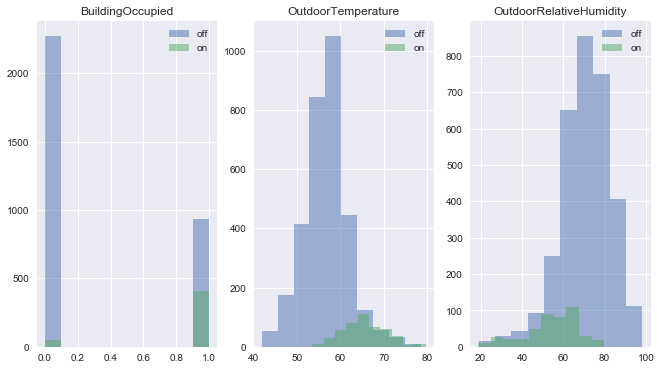

In [191]:
#Plot each feature separately by classification, see if any have clear class separability

#There are 8 predictors
fig, axes = plt.subplots(1, len(predictors_list), figsize=(11, 6))

axes = axes.ravel()

for i in range(X.shape[1]):
    axes[i].hist(X[(system_on_off==0) & ~np.isnan(X[:,i]),i], alpha=0.5, label='off')
    axes[i].hist(X[(system_on_off==1) & ~np.isnan(X[:,i]),i], alpha=0.5, label='on')
    axes[i].legend(loc='upper right')
    axes[i].set_title(predictors_list[i])

The nature of the data indicates that the cooling system tends to be on when the building is occupied, when it is warm, and when it is less humid. Low humidity and high temperature may be correlated, suggesting traditional models like logistic regression and linear regression may not perform as well.

I also note that I examined lagged sums of temperature in this graph (not shown here), and noted that class separability appeared visually worse doing this.

# Training/testing splits and modeling
Now I do 5 fold cross validation to train a logistic regression model, and when those results aren't promising I move to a random forest classification model.

In [192]:
n_folds = 5

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds)
skf.get_n_splits(X, y)

5

In [193]:
print(skf)  

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


In [194]:
#Instantiate model
from sklearn import linear_model
logistic_reg_model = linear_model.LogisticRegression(fit_intercept = True, class_weight='balanced', C=1)

In [195]:
counter = 0
scores = [None]*n_folds

for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(counter)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    est = logistic_reg_model.fit(X_train, y_train)
    scores[counter] = est.score(X_test, y_test)
    counter += 1

In [196]:
scores

[0.9659400544959128,
 0.88828337874659402,
 0.89358799454297411,
 0.86475409836065575,
 0.66120218579234968]

In [197]:
np.mean(scores)

0.8547535423876973

In [198]:
est = logistic_reg_model.fit(X, y)
train_on_all = est.score(X, y)

In [199]:
train_on_all

0.86275579809004088

This result is not promising. The average cross-validation score is 85% correct classification. Even training on all the training data yields 86% accuracy. However a null model that simply predicts the system is off all the time would have 87% accuracy, based on data exploration.

If I had more time, I'd explore the ROC curve and other thresholds, to see if better accuracy could be attained. I'd also explore methods for dealing with unbalanced classes as I have here, such as SMOTE.

Instead I move on directly to another classifier, random forest classifier.

In [204]:
#Instantiate model
from sklearn import ensemble
rf_model = ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                                              min_samples_split=2, min_samples_leaf=1,
                                              min_weight_fraction_leaf=0.0, max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_split=0, bootstrap=True, oob_score=False,
                                              n_jobs=1, random_state=None, verbose=0, warm_start=False,
                                              class_weight='balanced')

In [205]:
counter = 0
scores = [None]*n_folds

for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(counter)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    est = rf_model.fit(X_train, y_train)
    scores[counter] = est.score(X_test, y_test)
    counter += 1

In [206]:
scores

[0.91553133514986373,
 0.95912806539509532,
 0.94815825375170537,
 0.94398907103825136,
 0.85519125683060104]

In [207]:
np.mean(scores)

0.92439959643310343

This is an improvement on the null model and the logistic regression. After training on all the data, I proceed to next phase, modeling the actual loads. Here also is a very rudimentary plot of model goodness of fit in the form of average cross-validated accuracy, for the logistic regression first and the random forest next. With more time this would look better.

<Container object of 2 artists>

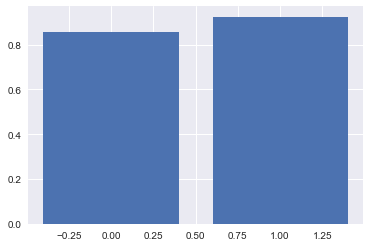

In [255]:
plt.bar([0, 1], [0.8547535423876973, 0.92439959643310343])

In [208]:
#Train on all data
est = rf_model.fit(X, y)
train_on_all = est.score(X, y)
train_on_all

0.99618008185538887

# Model 2: loads
Given the system is on, what is the load? I will use a simple multilinear regression, and maybe also try random forest regression.


In [209]:
#Subset the DF to only those times when the cooling system is turned on
df_train_loads = df_train[df_train.SystemOnOff.values == 1]

In [210]:
df_train_loads.head()

,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity,ThermalCoolingLoad,SystemOnOff,temp_ma
156,2/28/2017 15:00,1,55.400,57.45,200.3,1.0,329.034
157,2/28/2017 15:15,1,58.748,52.72,129.4,1.0,333.372
158,2/28/2017 15:30,1,57.776,52.14,127.2,1.0,336.630
159,2/28/2017 15:45,1,58.568,52.83,134.8,1.0,340.320
160,2/28/2017 16:00,1,58.190,51.87,131.5,1.0,343.470


In [211]:
df_train_loads.count()

Datetime                   462
BuildingOccupied           462
OutdoorTemperature         462
OutdoorRelativeHumidity    462
ThermalCoolingLoad         462
SystemOnOff                462
temp_ma                    462
dtype: int64

In [212]:
#Separate data into predictors and response
predictors_list = ['BuildingOccupied', 'OutdoorTemperature', 'OutdoorRelativeHumidity']#, 'temp_ma']
X = df_train_loads.filter(items=predictors_list).values
y = df_train_loads['ThermalCoolingLoad'].values

In [213]:
np.shape(X)

(462, 3)

In [214]:
np.shape(y)

(462,)

In [215]:
n_folds = 5

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds)
skf.get_n_splits(X, y)

5

In [216]:
print(skf)  

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


In [217]:
#Multiple linear regression
#Instantiate model
lin_reg_model = linear_model.LinearRegression(fit_intercept = True)


In [218]:
counter = 0
scores = [None]*n_folds

for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(counter)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    est = lin_reg_model.fit(X_train, y_train)
    scores[counter] = est.score(X_test, y_test)
    counter += 1

In [219]:
scores

[0.49392691772919828,
 0.38967542995456383,
 0.15034469222852809,
 0.38821936739561558,
 0.0]

In [225]:
est = lin_reg_model.fit(X, y)
train_on_all = est.score(X, y)
train_on_all

0.59126066973243874

These CV scores seem low. Now I try random forest regression.


In [221]:
rf_reg_model = ensemble.RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None,
                                              min_samples_split=2, min_samples_leaf=1,
                                              min_weight_fraction_leaf=0.0, max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_split=0, bootstrap=True, oob_score=False,
                                              n_jobs=1, random_state=None, verbose=0, warm_start=False)

In [222]:
counter = 0
scores = [None]*n_folds

for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(counter)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    est = rf_reg_model.fit(X_train, y_train)
    scores[counter] = est.score(X_test, y_test)
    counter += 1

In [223]:
scores

[0.54531580460341722,
 0.40803754469752962,
 0.48956991770091085,
 0.33440042262696257,
 0.0]

In [224]:
est = rf_reg_model.fit(X, y)
train_on_all = est.score(X, y)
train_on_all

0.93834056066075955

While the model testing scores here are not stellar by arbitrary standards, they are better than the linear regression. The last split again here is very poorly modeled when training on the first four, indicating there is some very important behavior here that is not captured in the other splits.

# Prediction
Now I build the overall prediction using the two models in sequence, so I can save the results to a CSV file.

In [226]:
df_predict.head()

,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity
0,1/1/2018 0:00,0,48.2,87
1,1/1/2018 0:30,0,48.2,87
2,1/1/2018 1:00,0,50.0,82
3,1/1/2018 1:30,0,50.0,82
4,1/1/2018 2:00,0,50.0,82


In [227]:
#First predict whether system is on or off
X_pred = df_predict.filter(items=predictors_list).values

In [228]:
np.shape(X_pred)

(17520, 3)

In [229]:
#Make binary prediction using random forest regression
y_pred = rf_model.predict(X_pred)

In [232]:
y_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [230]:
sum(y_pred)/float(len(y_pred))

0.12842465753424659

The system is predicted to be on about 13% of the time, which makes sense based on the training data.

Now to predict the loads at these times.

In [237]:
X_pred_2 = X_pred[y_pred==1,:]

In [238]:
np.shape(X_pred_2)

(2250, 3)

In [239]:
y_pred_2 = rf_reg_model.predict(X_pred_2)

In [241]:
np.mean(y_pred_2)

268.63959111111109

In [242]:
np.mean(y)

233.26125541125541

The average predicted cooling load is on the same order of magnitude as the training data, which seems sensible. Now to add predictions to the data frame, for printing to CSV.

In [243]:
df_predict['SystemOnOff'] = y_pred

In [244]:
df_predict.head()

,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity,SystemOnOff
0,1/1/2018 0:00,0,48.2,87,0.0
1,1/1/2018 0:30,0,48.2,87,0.0
2,1/1/2018 1:00,0,50.0,82,0.0
3,1/1/2018 1:30,0,50.0,82,0.0
4,1/1/2018 2:00,0,50.0,82,0.0


In [245]:
df_predict['ThermalCoolingLoad'] = np.zeros(np.shape(y_pred))

In [246]:
df_predict.head()

,Datetime,BuildingOccupied,OutdoorTemperature,OutdoorRelativeHumidity,SystemOnOff,ThermalCoolingLoad
0,1/1/2018 0:00,0,48.2,87,0.0,0.0
1,1/1/2018 0:30,0,48.2,87,0.0,0.0
2,1/1/2018 1:00,0,50.0,82,0.0,0.0
3,1/1/2018 1:30,0,50.0,82,0.0,0.0
4,1/1/2018 2:00,0,50.0,82,0.0,0.0


In [248]:
df_predict.loc[y_pred==1, ['ThermalCoolingLoad']] = y_pred_2

In [250]:
new_df_for_csv = df_predict.filter(items = ['Datetime', 'SystemOnOff', 'ThermalCoolingLoad'])

In [252]:
new_df_for_csv.to_csv('ThermalCoolingLoad_predictions.csv', index=False)

# Conclusion
Overall, I used a random forest classifier to classify times when the cooling system was on, and then a random forest regression to calculate the actual loads at these times. There are several things I would explore with more time, that are already mentioned. Additionally, I would like to have tried boosted trees, which can provide additional performance over Random Forest.